In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load Data and keep year from release date
data = pd.read_csv("./data/movie_data_imdbscores.csv")
data.release_date = pd.to_datetime(data.release_date).apply(lambda x: x.year)


# Select features to keep in analysis


# WE DO NOT KEEP RUN TIME AND ACTOR AGE AT MOVIE RELEASE BECAUSE OF NA


to_keep = ['movie_id', 'release_date', 
           #'runtime', 'actor_age_at_movie_release',
       'english language','german language', 'silent film language', 'spanish language',
       'japanese language', 'italian language', 'tamil language',
       'hindi language', 'malayalam language', 'mandarin language',
       'french language', 'Action', 'Adventure', 'Horror', 'Thriller', 'Drama',
       'Crime Fiction', 'Black-and-white', 'Comedy', 'Indie', 'Short Film',
       'Silent film', 'Family Film', 'World cinema', 'Musical',
       'Action/Adventure', 'Romance Film', 'Romantic drama', 'Comedy film',
       'Documentary', 'F_gender_porportion', 'averageRating',
       'numVotes']
data = data[to_keep].set_index('movie_id')

In [3]:
data = data.rename(lambda d: d.replace(' ', '_'), axis = 1)
data = data.rename(lambda d: d.replace('-', '_'), axis = 1)

In [4]:
data.head()

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action/Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_porportion,averageRating,numVotes
movie_id,,,,,,,,,,,,,,,,,,,,,
30332673,2010,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.666667,3.7,3222
4213160,1971,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,0.250000,6.3,2631
20624798,2008,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,0.111111,7.2,22
2250713,1988,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.000000,5.9,82
25969588,2007,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.200000,6.4,346


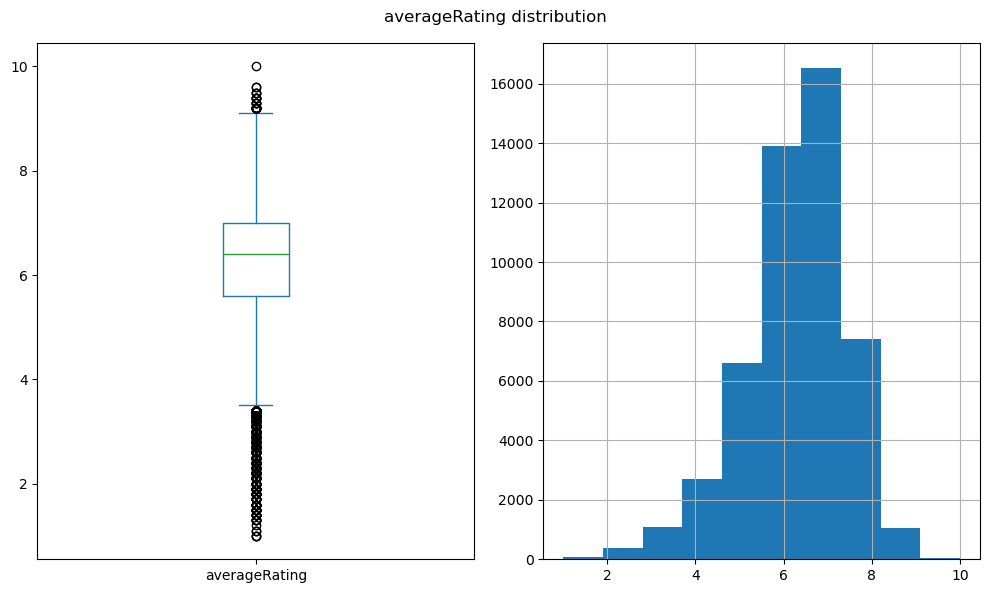

In [5]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0])
data.averageRating.hist(ax = ax[1])
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.show()

In [6]:
data.averageRating.describe()

count    49785.000000
mean         6.224752
std          1.146467
min          1.000000
25%          5.600000
50%          6.400000
75%          7.000000
max         10.000000
Name: averageRating, dtype: float64

In [7]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

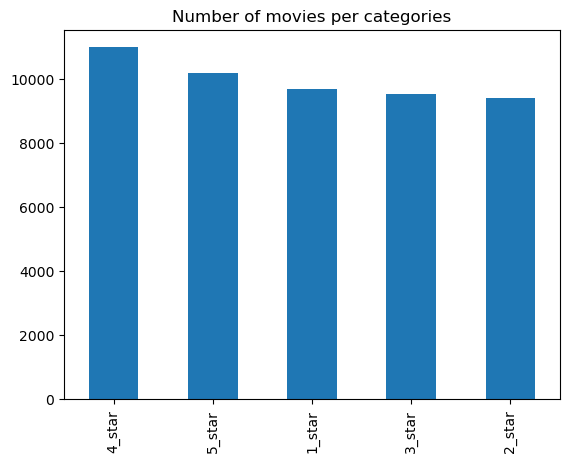

In [8]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)

# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar()
plt.title("Number of movies per categories")
plt.show()

In [9]:
# Compute mean proportions and means for numeric values
grouped = data.groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action/Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_porportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
2_star,1977.950340,0.653764,0.019779,0.031370,0.028286,0.018928,0.029775,0.015951,0.045725,0.010102,...,0.089217,0.056678,0.091876,0.167695,0.055402,0.044981,0.009251,0.339252,5.724777,4220.002765
3_star,1976.805981,0.635467,0.021091,0.026758,0.034523,0.026967,0.035047,0.014376,0.041763,0.009759,...,0.100630,0.059916,0.085729,0.169780,0.063694,0.038300,0.015110,0.341454,6.304344,6221.281637
4_star,1977.724399,0.572613,0.035714,0.028972,0.045554,0.032799,0.038356,0.017128,0.048925,0.013484,...,0.140671,0.060313,0.072977,0.165270,0.067875,0.033072,0.024690,0.335895,6.842365,9172.384111
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


In [10]:
# Visualize the best and worst scoring groups

grouped_means.iloc[[0,-1], :]

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action/Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_porportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


In [11]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):
    
    # Sidak correction with k = n_tests
    alpha_c = 1 - (1 - alpha)**(1/n_tests)

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha_c:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha_c:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")
    
    return pvalues

In [12]:
# Divide dataset for logistic regression

# 1 vs all approach

def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['1vsall'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)

y = data['1vsall']

x_ = data.drop(['score_discretized', 'averageRating', 'numVotes', '1vsall'], axis = 1)

numerics = ['release_date', 'F_gender_porportion']

X = x_.copy()

# Standardize numeric values
X[numerics] = (x_[numerics] - x_[numerics].mean(axis = 0)) / x_[numerics].std(axis = 0)
X = X.apply(lambda f: f.astype(float))

In [13]:
mean_diff_data = pd.merge(X.copy(), y, left_index=True, right_index=True)
mean_diff_data = mean_diff_data.groupby('1vsall').mean()
mean_diff = mean_diff_data.iloc[0] - mean_diff_data.iloc[1]

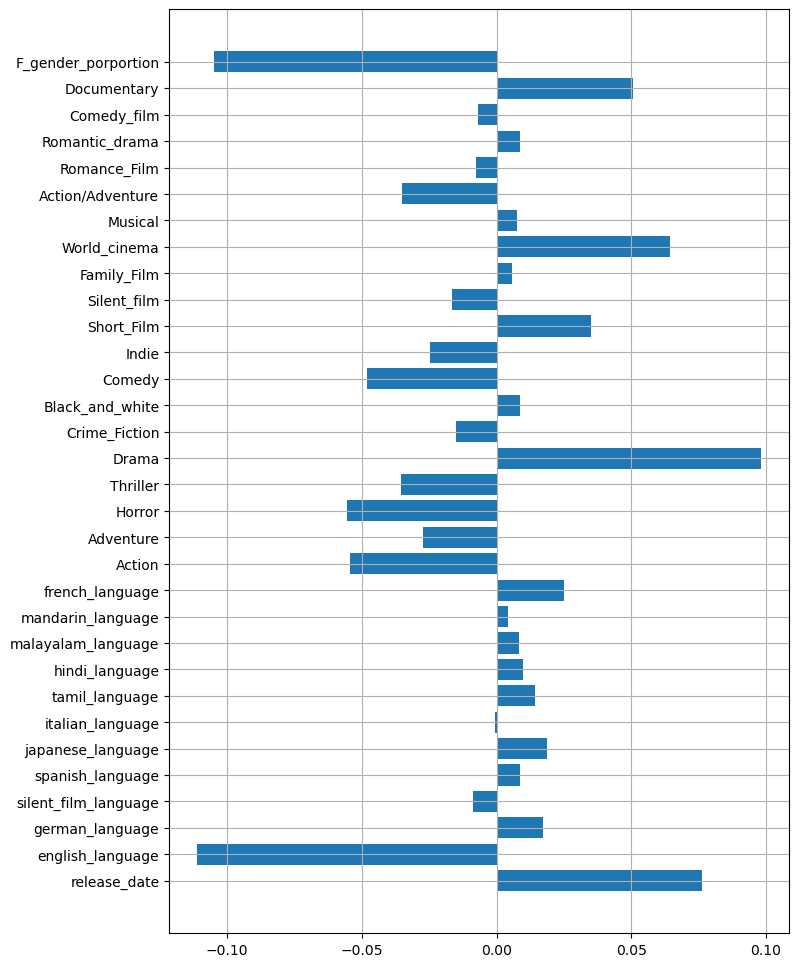

In [14]:
plt.figure(figsize= (8,12))
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), labels = mean_diff.index)
plt.grid()
plt.show()

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df = pd.merge(X.copy(), y, left_index=True, right_index=True)
df['1vsall'] = (df['1vsall'] == '5_star').astype(float)
df = df.rename(columns={'1vsall': 'critical_darling'})
cols = ' + '.join(df.drop('critical_darling', axis=1).columns)
model = smf.ols(formula=f'critical_darling ~ {cols}', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       critical_darling   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     99.45
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:31:04   Log-Likelihood:                -23894.
No. Observations:               49785   AIC:                         4.785e+04
Df Residuals:                   49752   BIC:                         4.815e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1977 

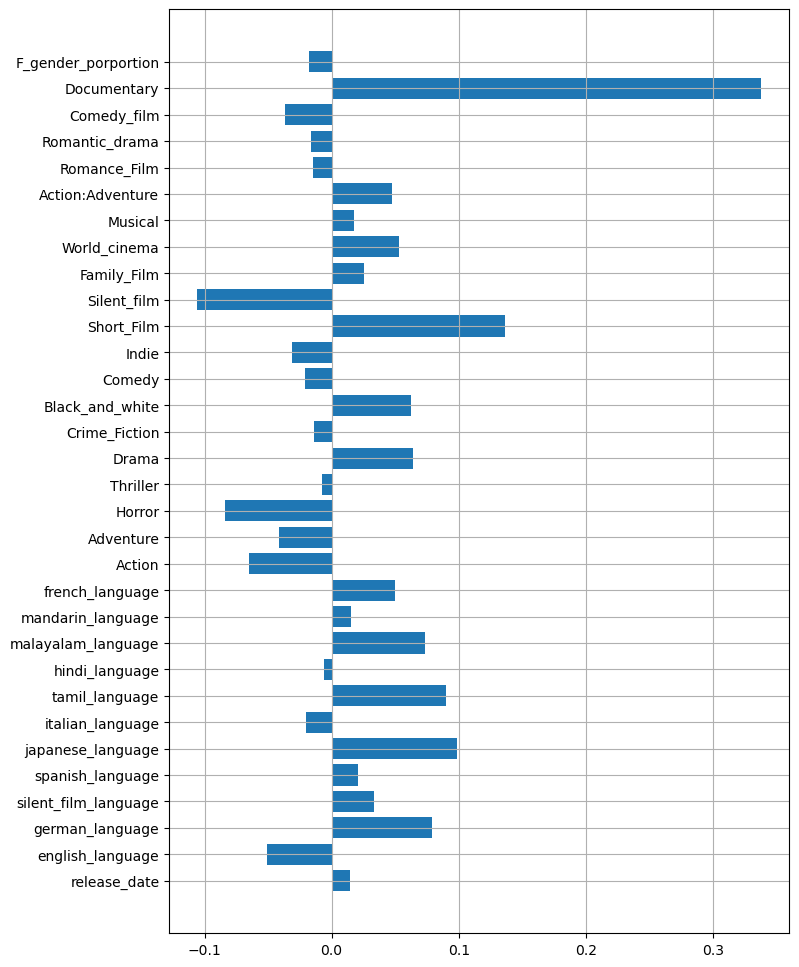

In [26]:
coefs = model.params.drop('Intercept')
plt.figure(figsize= (8,12))
plt.barh(range(len(coefs)), coefs)
plt.yticks(range(len(coefs)), labels = coefs.index)
plt.grid()
plt.show()

In [16]:
# Fit Model and retrieve coefficients
lr = LogisticRegression()
lr.fit(X,y)
coefs = lr.coef_.flatten()
print(f'Accuracy: {lr.score(X, y)}')

Accuracy: 0.797147735261625


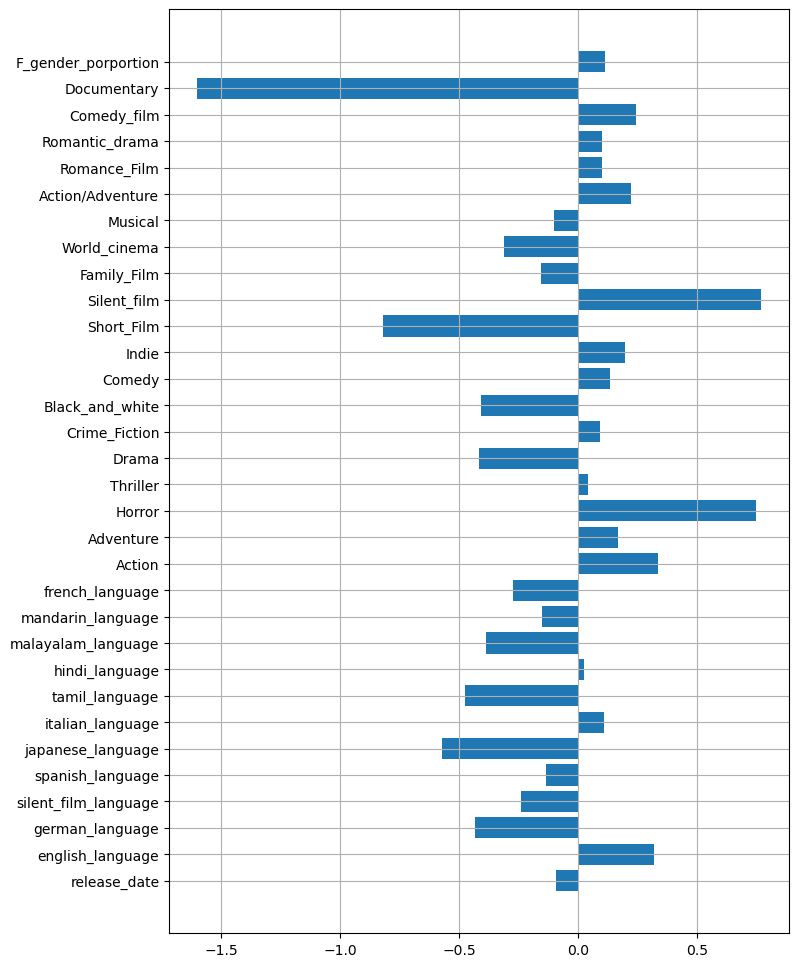

In [17]:
# Plot coefficients
plt.figure(figsize= (8,12))
plt.barh(range(len(coefs)), coefs)
plt.yticks(range(len(coefs)), labels = x_.columns)
plt.grid()
plt.show()

In [18]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": lr.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.4058890298457635, best cutoff: 0.20833333333333331, best accuracy: 0.6425429346188611


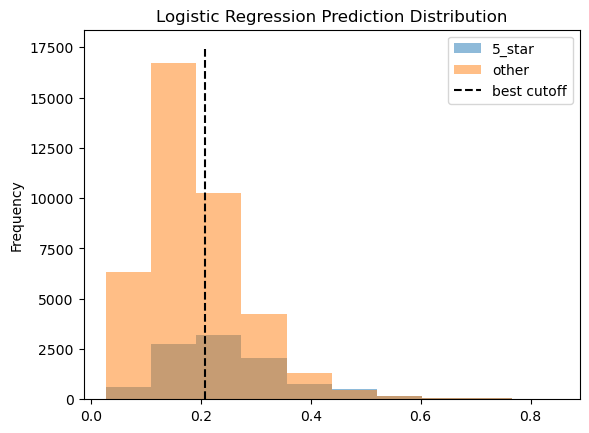

In [19]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Logistic Regression Prediction Distribution")
plt.vlines(best_cutoff, 0, 17500, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

In [20]:
rf = RandomForestClassifier(10)

rf.fit(X, y)

importances = rf.feature_importances_

print(f"Random Forest accuracy: {rf.score(X, y)}")

Random Forest accuracy: 0.9501456261926283


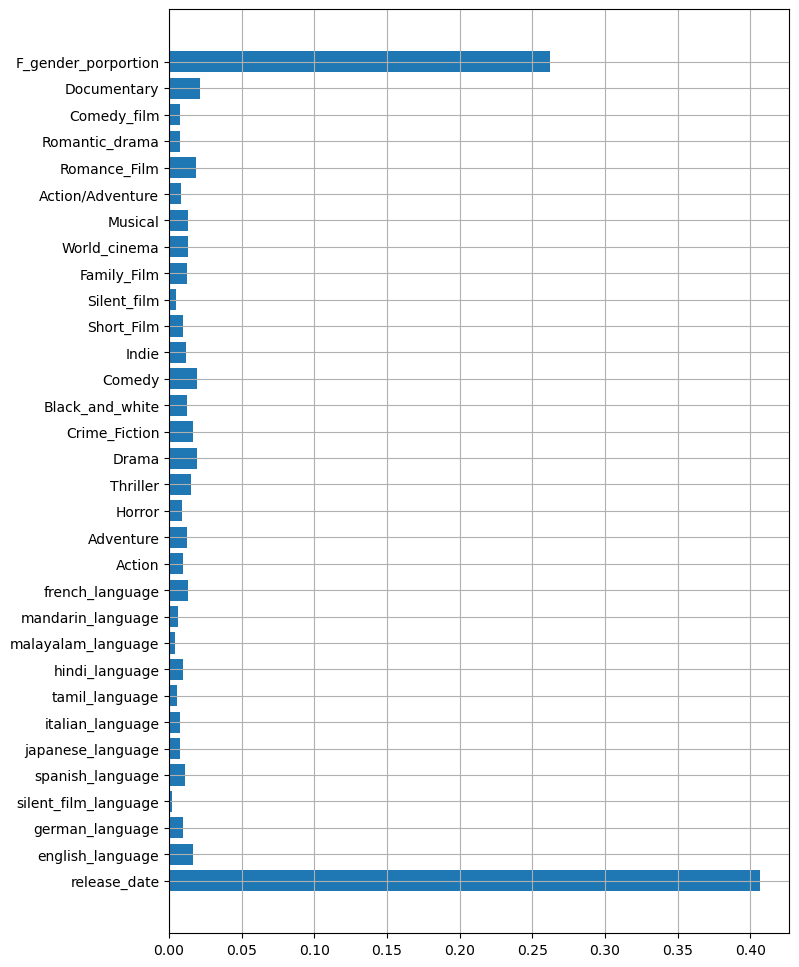

In [21]:
# Plot importances
plt.figure(figsize= (8,12))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), labels = x_.columns)
plt.grid()
plt.show()

In [22]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": rf.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

KeyboardInterrupt: 

In [ ]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Random Forest Classifier Prediction Distribution")
plt.vlines(best_cutoff, 0, 25000, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

In [ ]:
# Release date appears to be important in RF Lets plot its distribution

data.pivot(values = 'release_date', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

In [ ]:
# apparently also gender?

data.pivot(values = 'F_gender_porportion', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

At first glance I cannot find any difference in the distributions. So the Random Forest has to be able to figure out the combinations to make it better.

In [ ]:


# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(data.groupby('1vsall'), 2):
    
    # Drop the separating feature
    vars = df_1.columns.drop(['1vsall','score_discretized'])
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)